Epoch 1/5, Train Loss: 0.2228, Val Loss: 0.1718
Epoch 2/5, Train Loss: 0.1386, Val Loss: 0.1157
Epoch 3/5, Train Loss: 0.1091, Val Loss: 0.0857
Epoch 4/5, Train Loss: 0.0911, Val Loss: 0.0629
Epoch 5/5, Train Loss: 0.0739, Val Loss: 0.0555


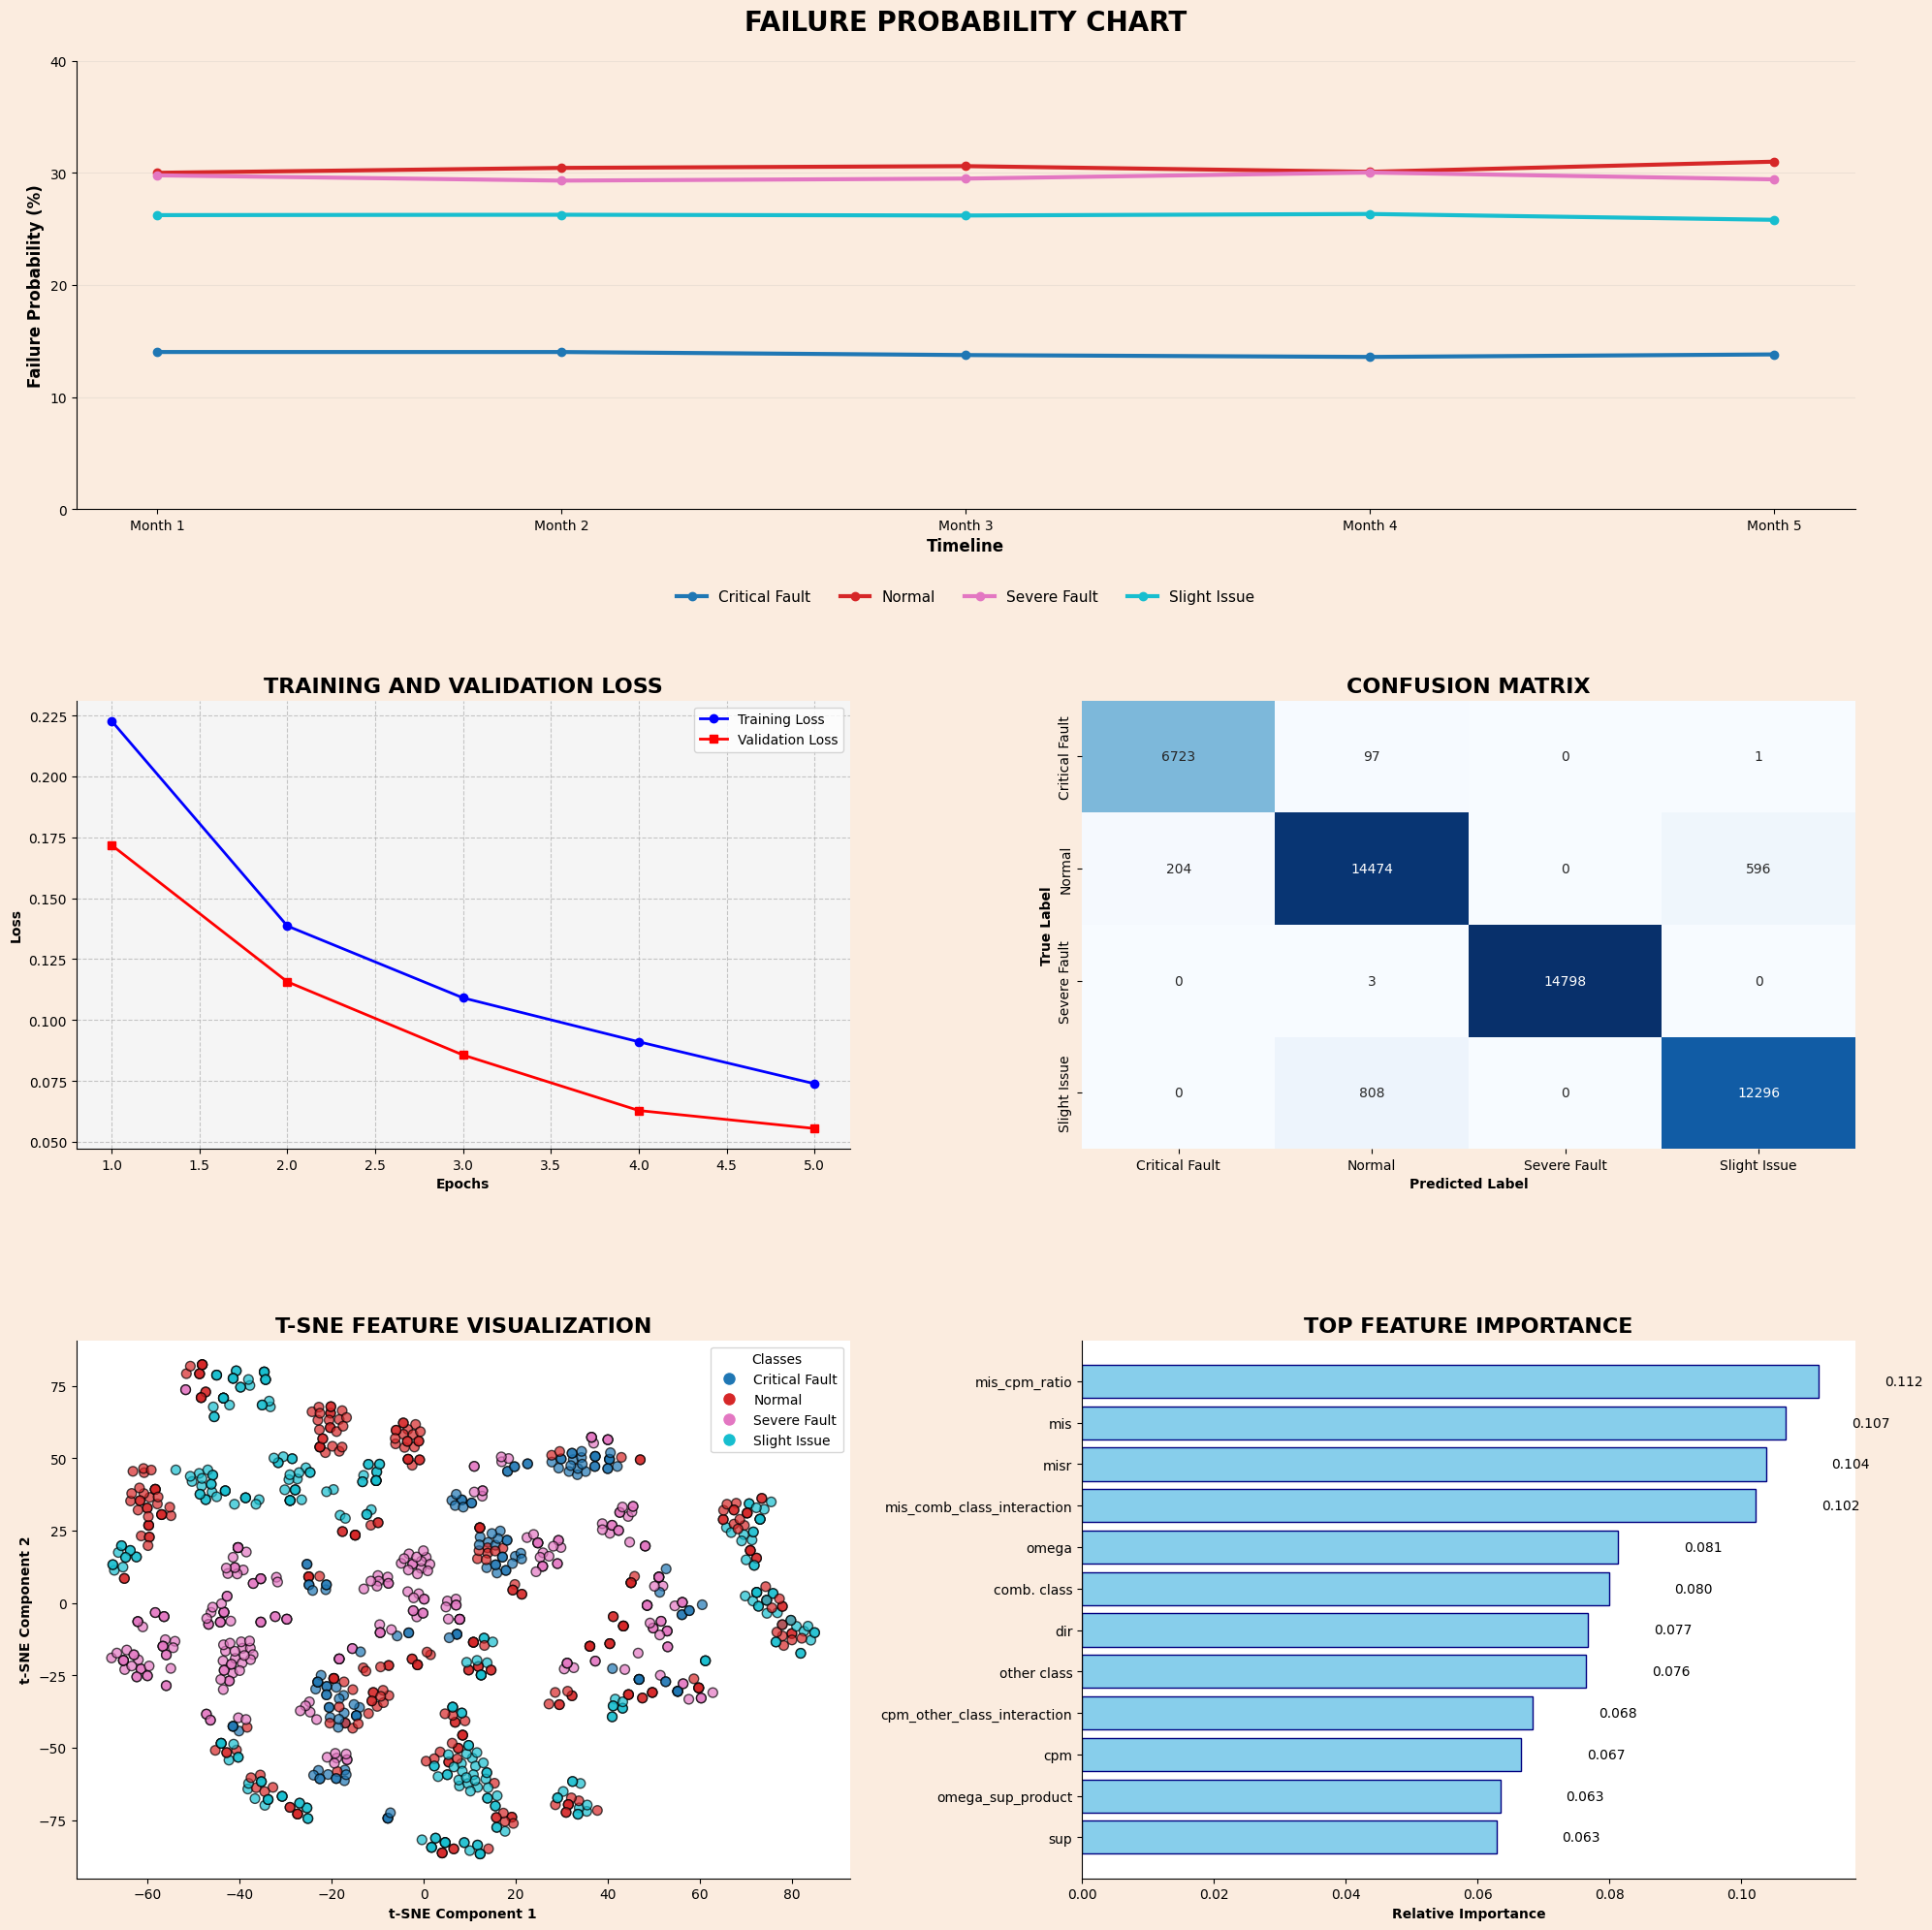

<Figure size 1000x800 with 0 Axes>

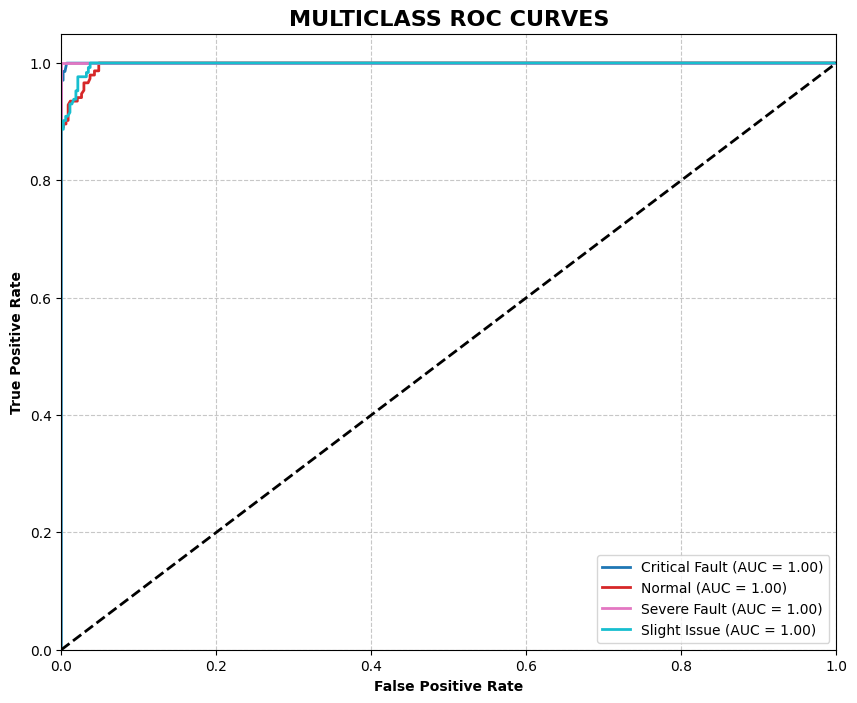

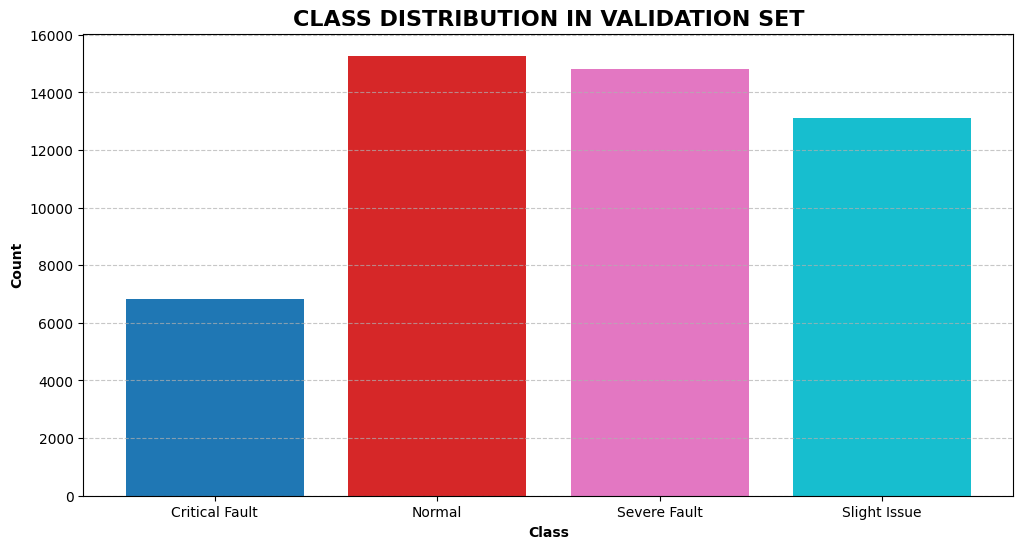

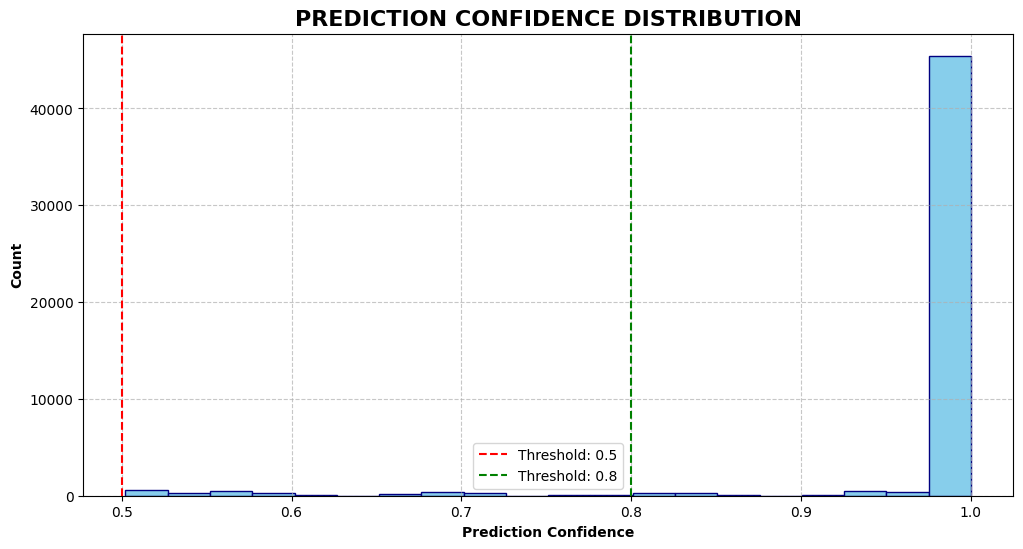


Classification Report:
                precision    recall  f1-score   support

Critical Fault       0.97      0.99      0.98      6821
        Normal       0.94      0.95      0.94     15274
  Severe Fault       1.00      1.00      1.00     14801
  Slight Issue       0.95      0.94      0.95     13104

      accuracy                           0.97     50000
     macro avg       0.97      0.97      0.97     50000
  weighted avg       0.97      0.97      0.97     50000


Overall Model Performance:
Accuracy: 0.9658
AUC Score (OVR): 0.9988092984366329


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from scipy import stats

# Load dataset
df = pd.read_csv("mechanical_analysis_named.csv")


# Encode all categorical columns
def encode_categorical(df):
    label_encoders = {}
    for col in df.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df, label_encoders

df, label_encoders = encode_categorical(df)

# Feature Engineering
df["mis_cpm_ratio"] = df["mis"] / (df["cpm"] + 1e-6)  # Avoid division by zero
df["omega_sup_product"] = df["omega"] * df["sup"]
df["mis_comb_class_interaction"] = df["mis"] * df["comb. class"]
df["cpm_other_class_interaction"] = df["cpm"] * df["other class"]

# Define features and target
features = df.drop(columns=["class", "instance", "number"], errors='ignore')  # Exclude irrelevant columns
target = df["class"]

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert to tensors
X = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.long)

# Split dataset
train_size = int(0.8 * len(df))
val_size = len(df) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X, y), [train_size, val_size])

# Data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x).squeeze(1)
        return self.fc(x)

# Initialize model
input_dim = X.shape[1]
num_classes = len(df["class"].unique())
model = TransformerModel(input_dim, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        epoch_train_loss = train_loss/len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        epoch_val_loss = val_loss/len(val_loader)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}")
    
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# Collect all predictions and true labels
all_outputs = []
all_labels = []
model.eval()
with torch.no_grad():
    for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_outputs = np.vstack(all_outputs)
all_labels = np.hstack(all_labels)
y_pred_probs = np.exp(all_outputs) / np.sum(np.exp(all_outputs), axis=1, keepdims=True)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract validation dataset features and labels for TSNE
val_features = []
val_labels = []
for data, labels in val_loader:
    val_features.append(data.cpu().numpy())
    val_labels.append(labels.cpu().numpy())
val_features = np.vstack(val_features)
val_labels = np.hstack(val_labels)

# Get class names
if "class" in label_encoders:
    class_names = label_encoders["class"].classes_
else:
    class_names = [f"Class {i}" for i in range(num_classes)]

# Create a figure with multiple subplots
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

# Define color palette for consistency across plots
# Use a color palette with enough distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
cmap = ListedColormap(colors)

# 1. MAIN FAILURE PROBABILITY CHART (similar to the reference)
ax1 = plt.subplot(gs[0, :])
# Set background color
ax1.set_facecolor('#fbecdf')
plt.gcf().patch.set_facecolor('#fbecdf')

# Sample data for each class (using average probabilities per class)
class_data = {}
for i in range(num_classes):
    # Get average probability values for 5 different segments
    num_segments = 5
    segment_size = len(y_pred_probs) // num_segments
    class_data[i] = [np.mean(y_pred_probs[s*segment_size:(s+1)*segment_size, i]) * 100 for s in range(num_segments)]

# Plot each class line
for i, (class_idx, values) in enumerate(class_data.items()):
    ax1.plot(range(1, 6), values, marker='o', linewidth=3, color=colors[i], label=class_names[class_idx])

# Set the x-axis labels
ax1.set_xticks(range(1, 6))
ax1.set_xticklabels([f'Month {i}' for i in range(1, 6)])
ax1.set_xlabel('Timeline', fontsize=12, fontweight='bold')

# Set the y-axis range and label
max_value = max([max(values) for values in class_data.values()])
y_max = max(40, (max_value // 10 + 1) * 10)  # Round up to nearest 10, minimum 40
ax1.set_ylim(0, y_max)
ax1.set_yticks(range(0, y_max + 1, 10))
ax1.set_ylabel('Failure Probability (%)', fontsize=12, fontweight='bold')

# Add grid lines (horizontal only, light gray)
ax1.grid(axis='y', linestyle='-', alpha=0.2)

# Remove spines
for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)

# Add title
ax1.set_title('FAILURE PROBABILITY CHART', fontsize=20, fontweight='bold', y=1.05)

# Calculate number of columns for the legend based on number of classes
legend_cols = min(4, num_classes)
# Place legend at the bottom
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=legend_cols, frameon=False, fontsize=11)

# 2. TRAINING AND VALIDATION LOSS
ax2 = plt.subplot(gs[1, 0])
ax2.set_facecolor('#f5f5f5')
epochs = range(1, len(train_losses) + 1)
ax2.plot(epochs, train_losses, 'b-', linewidth=2, marker='o', label='Training Loss')
ax2.plot(epochs, val_losses, 'r-', linewidth=2, marker='s', label='Validation Loss')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('Loss', fontweight='bold')
ax2.set_title('TRAINING AND VALIDATION LOSS', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, linestyle='--', alpha=0.7)
for spine in ['top', 'right']:
    ax2.spines[spine].set_visible(False)

# 3. CONFUSION MATRIX
ax3 = plt.subplot(gs[1, 1])
cm = confusion_matrix(all_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax3)
ax3.set_xlabel('Predicted Label', fontweight='bold')
ax3.set_ylabel('True Label', fontweight='bold')
ax3.set_title('CONFUSION MATRIX', fontsize=16, fontweight='bold')
ax3.set_xticklabels(class_names)
ax3.set_yticklabels(class_names)

# 4. T-SNE VISUALIZATION OF FEATURES
# Reduce dimensionality with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
# Use a subset of data if there's too much
max_samples = 1000
if len(val_features) > max_samples:
    idx = np.random.choice(len(val_features), max_samples, replace=False)
    tsne_features = val_features[idx]
    tsne_labels = val_labels[idx]
else:
    tsne_features = val_features
    tsne_labels = val_labels

tsne_results = tsne.fit_transform(tsne_features)

ax4 = plt.subplot(gs[2, 0])
scatter = ax4.scatter(tsne_results[:, 0], tsne_results[:, 1], c=tsne_labels, cmap=cmap, alpha=0.7, s=50, edgecolors='k')
ax4.set_title('T-SNE FEATURE VISUALIZATION', fontsize=16, fontweight='bold')
ax4.set_xlabel('t-SNE Component 1', fontweight='bold')
ax4.set_ylabel('t-SNE Component 2', fontweight='bold')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=class_names[i]) 
                  for i in range(num_classes)]
ax4.legend(handles=legend_handles, title='Classes', loc='best')
for spine in ['top', 'right']:
    ax4.spines[spine].set_visible(False)

# 5. FEATURE IMPORTANCE
# Get feature importance from model weights (approximation)
with torch.no_grad():
    # Get weights from first layer
    weights = model.embedding.weight.cpu().numpy()
    # Sum absolute weights to get importance
    importance = np.sum(np.abs(weights), axis=0)
    # Normalize importance
    importance = importance / np.sum(importance)

# Get feature names
feature_names = df.drop(columns=["class", "instance", "number"], errors='ignore').columns.tolist()

# Sort features by importance
sorted_idx = np.argsort(importance)[::-1][:min(15, len(feature_names))]  # Top 15 features
sorted_importance = importance[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

ax5 = plt.subplot(gs[2, 1])
ax5.barh(range(len(sorted_features)), sorted_importance, color='skyblue', edgecolor='navy')
ax5.set_yticks(range(len(sorted_features)))
ax5.set_yticklabels(sorted_features)
ax5.set_title('TOP FEATURE IMPORTANCE', fontsize=16, fontweight='bold')
ax5.set_xlabel('Relative Importance', fontweight='bold')
ax5.invert_yaxis()  # Most important at the top
for spine in ['top', 'right']:
    ax5.spines[spine].set_visible(False)

# Add values to the end of bars
for i, v in enumerate(sorted_importance):
    ax5.text(v + 0.01, i, f'{v:.3f}', va='center')

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Save the multi-panel figure
plt.savefig('advanced_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate additional plots in separate figures

# ROC Curve for multiclass
plt.figure(figsize=(10, 8))
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
lw = 2
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('MULTICLASS ROC CURVES', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Class distribution plot
plt.figure(figsize=(12, 6))
class_counts = np.bincount(val_labels.astype(int))
plt.bar(range(len(class_counts)), class_counts, color=colors[:len(class_counts)])
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('CLASS DISTRIBUTION IN VALIDATION SET', fontsize=16, fontweight='bold')
plt.xticks(range(len(class_counts)), class_names)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Prediction confidence distribution
plt.figure(figsize=(12, 6))
confidence = np.max(y_pred_probs, axis=1)
plt.hist(confidence, bins=20, color='skyblue', edgecolor='navy')
plt.xlabel('Prediction Confidence', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('PREDICTION CONFIDENCE DISTRIBUTION', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold: 0.5')
plt.axvline(x=0.8, color='green', linestyle='--', label='Threshold: 0.8')
plt.legend()
plt.savefig('prediction_confidence.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, y_pred, target_names=class_names))

# Calculate and display overall model performance metrics
accuracy = accuracy_score(all_labels, y_pred)
try:
    auc_score = roc_auc_score(all_labels, y_pred_probs, multi_class='ovr')
except:
    auc_score = "N/A"  # Handle potential errors with AUC calculation

print(f"\nOverall Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score (OVR): {auc_score}")

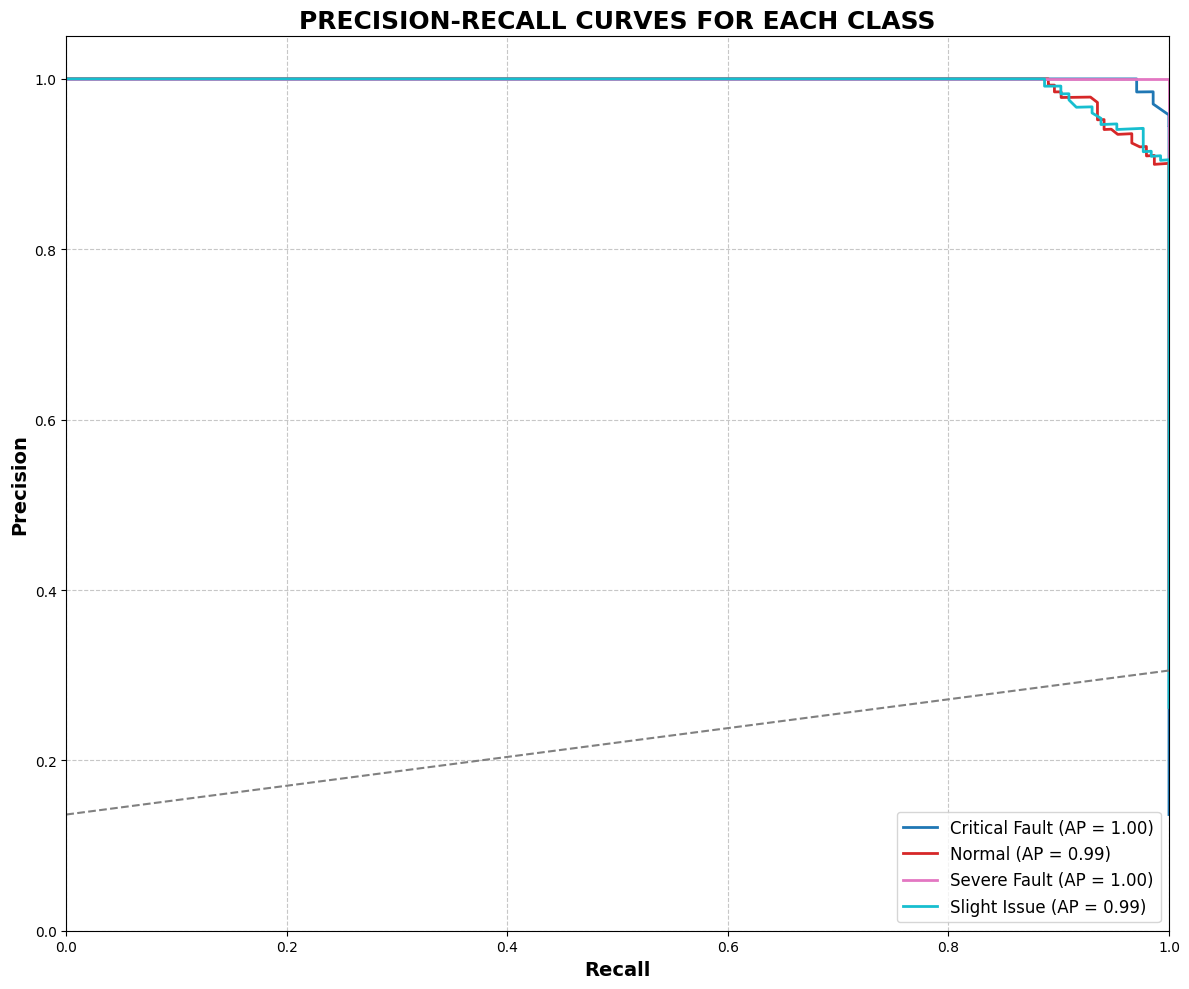

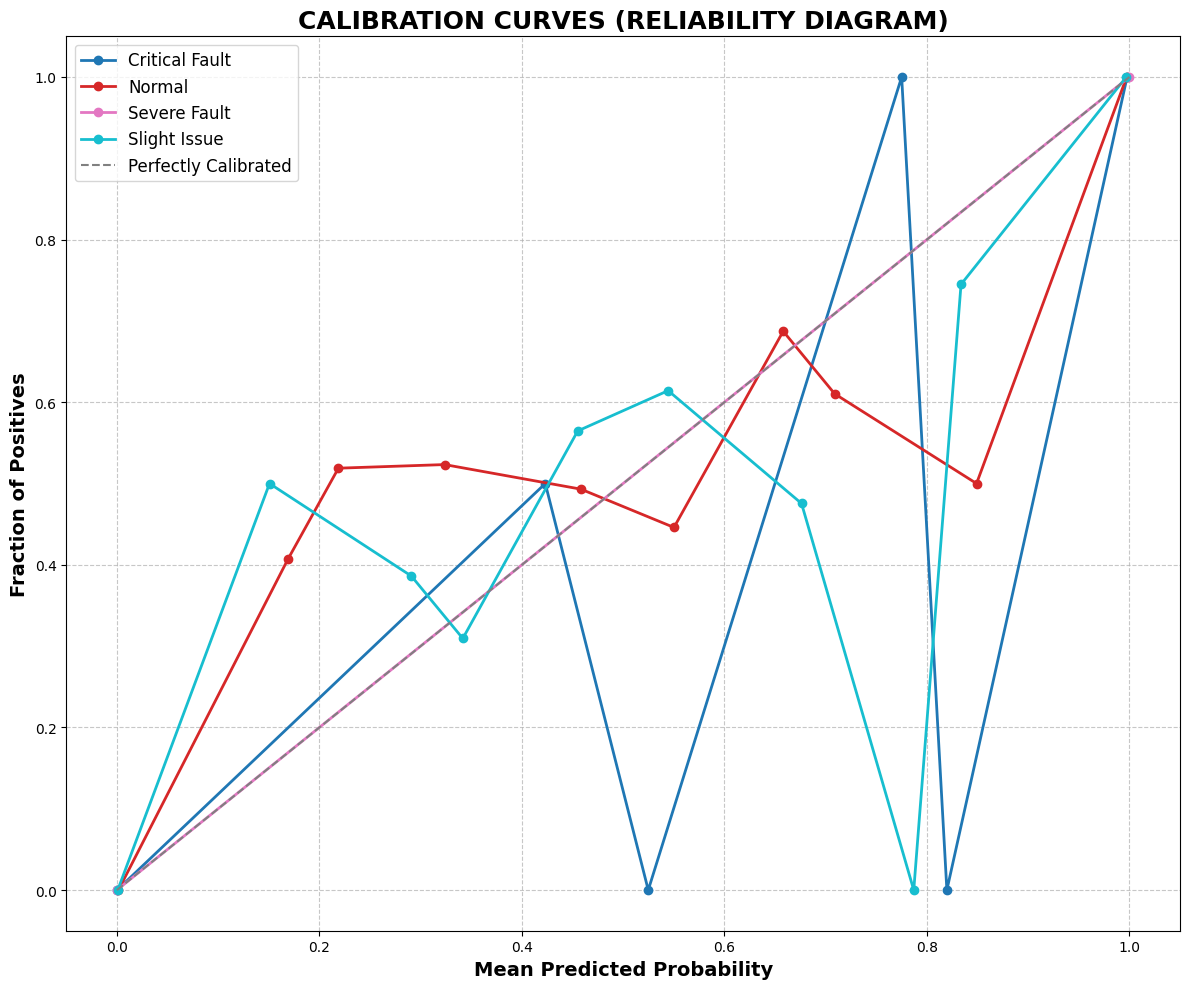

<Figure size 1600x1400 with 0 Axes>

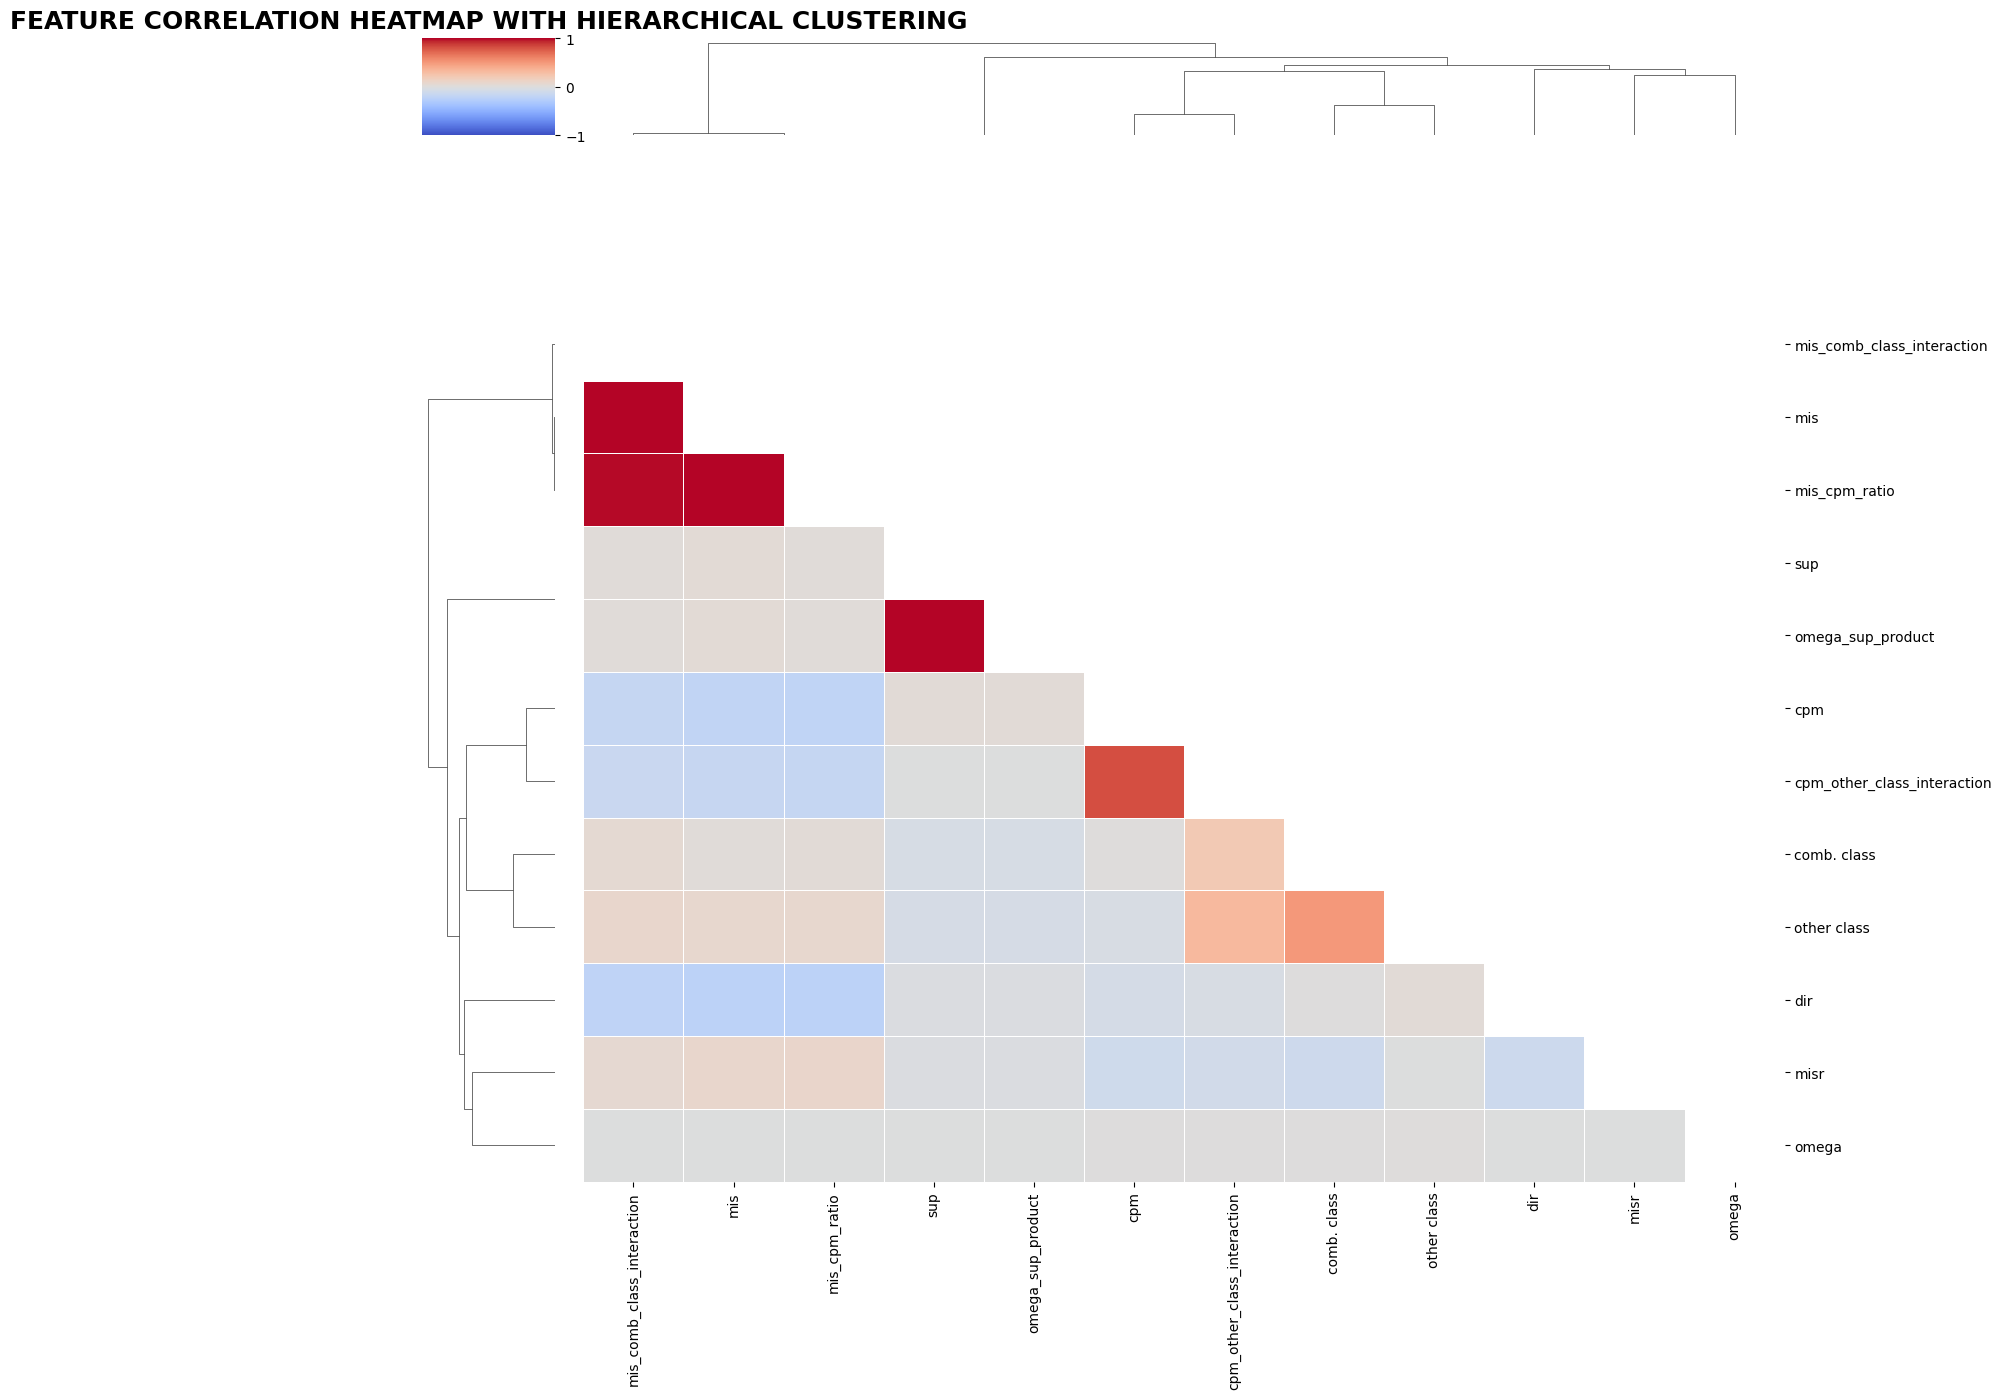

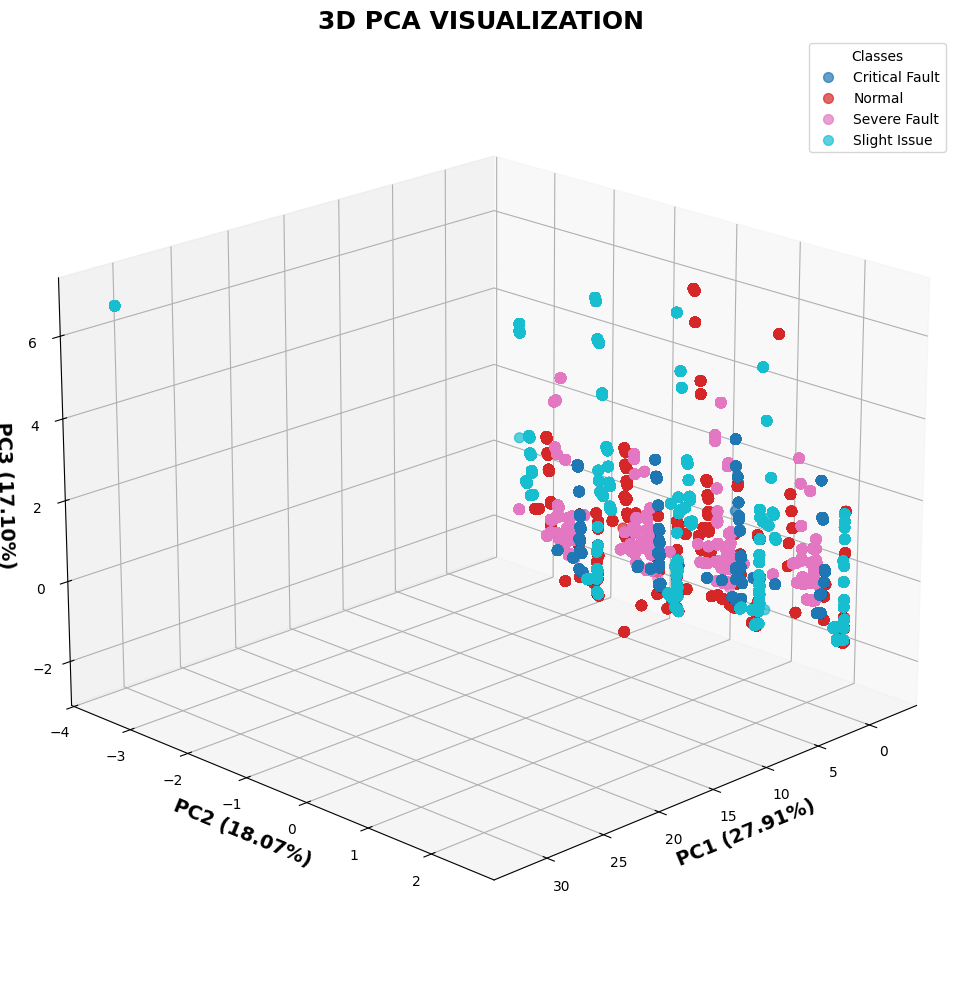

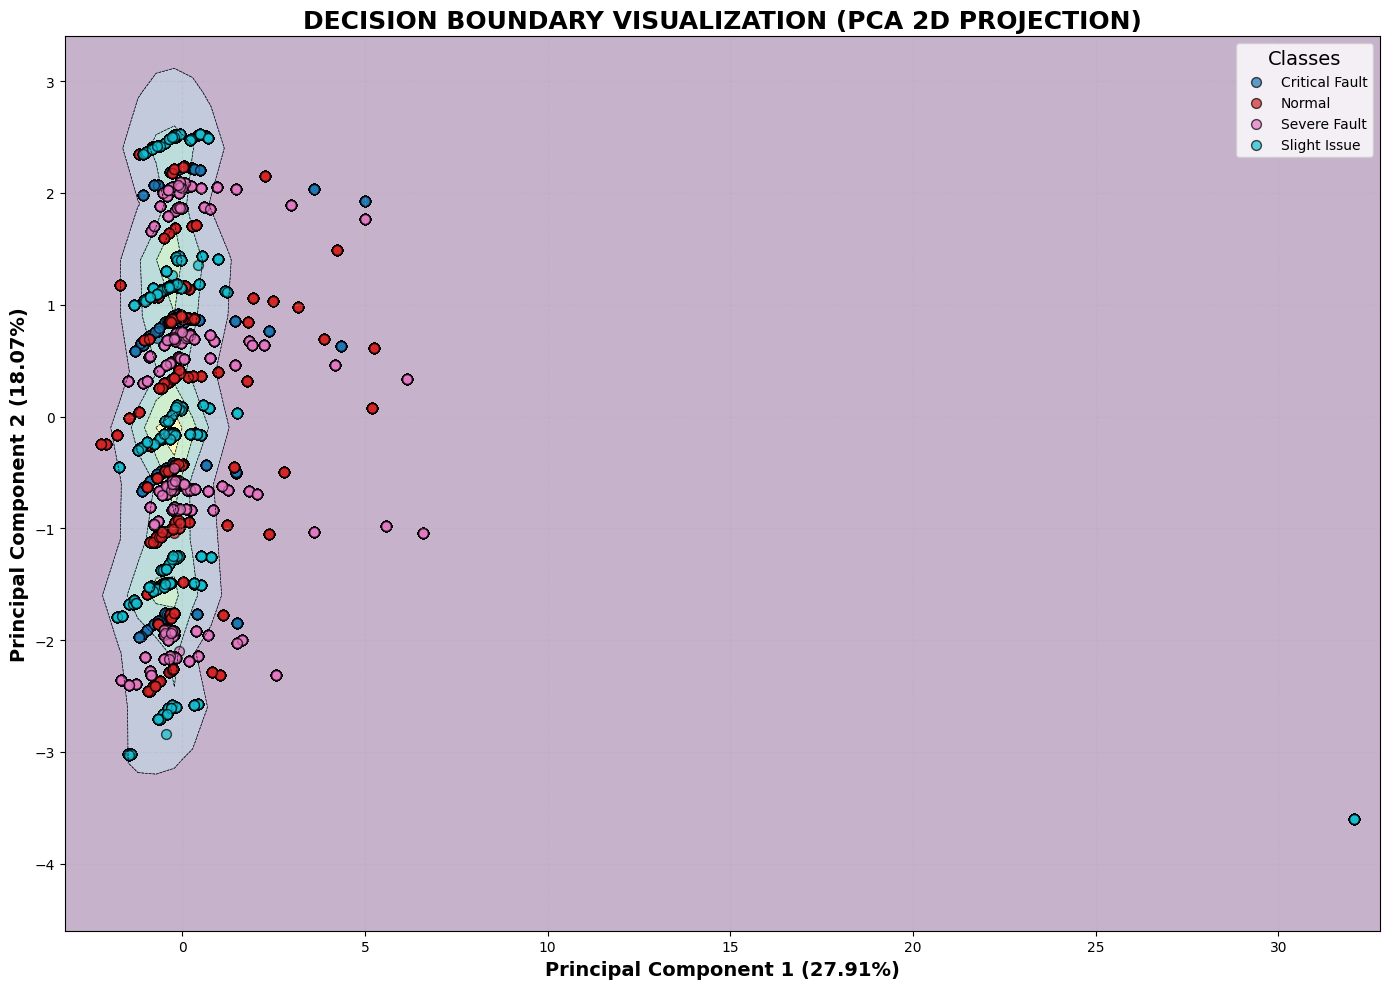

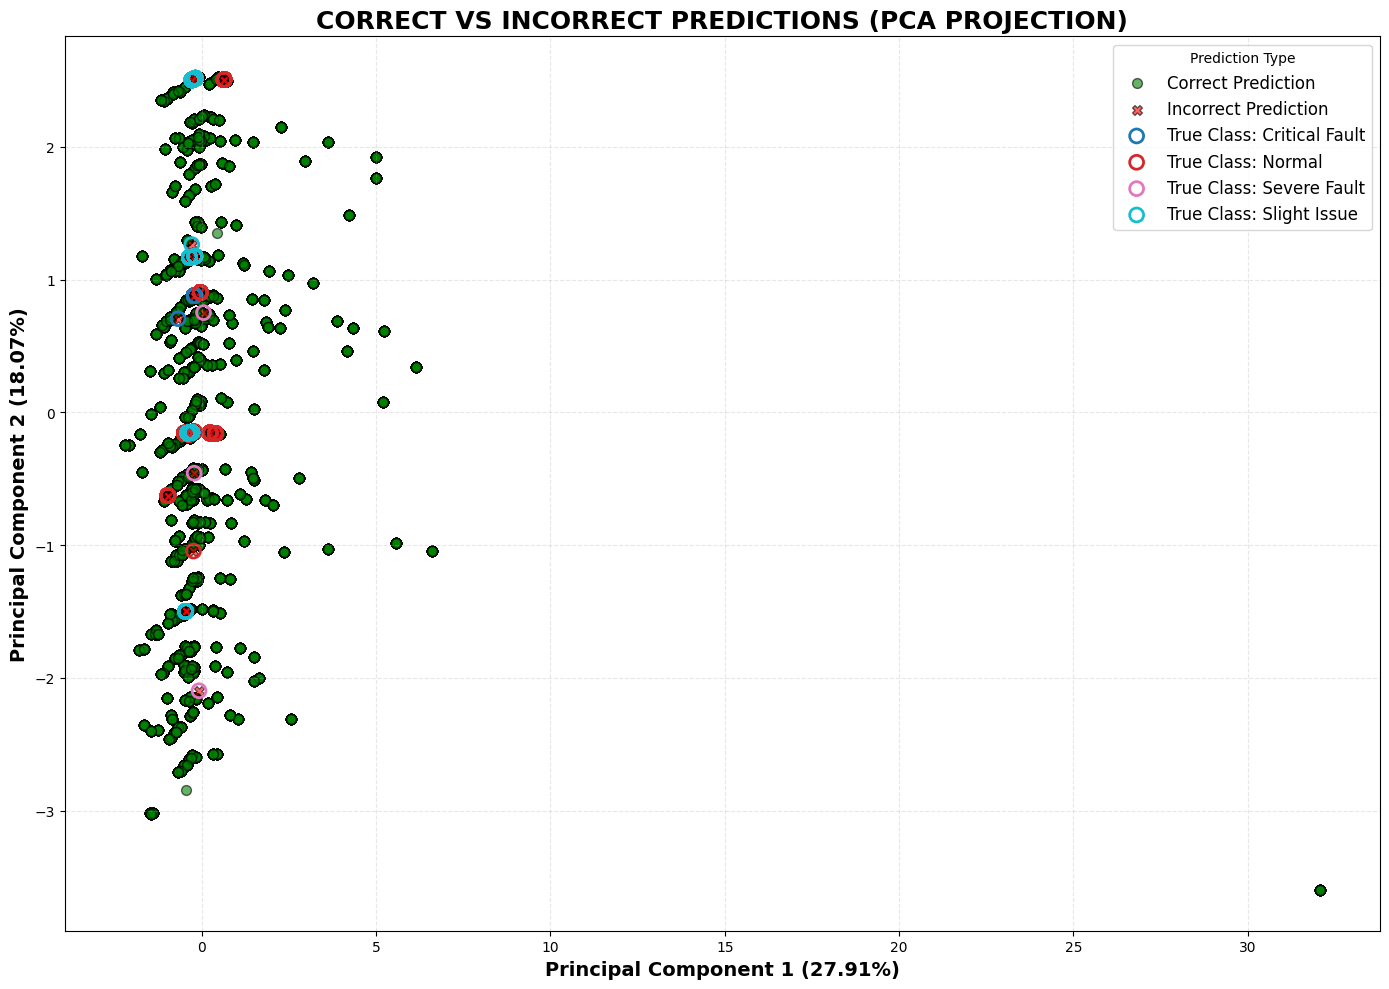

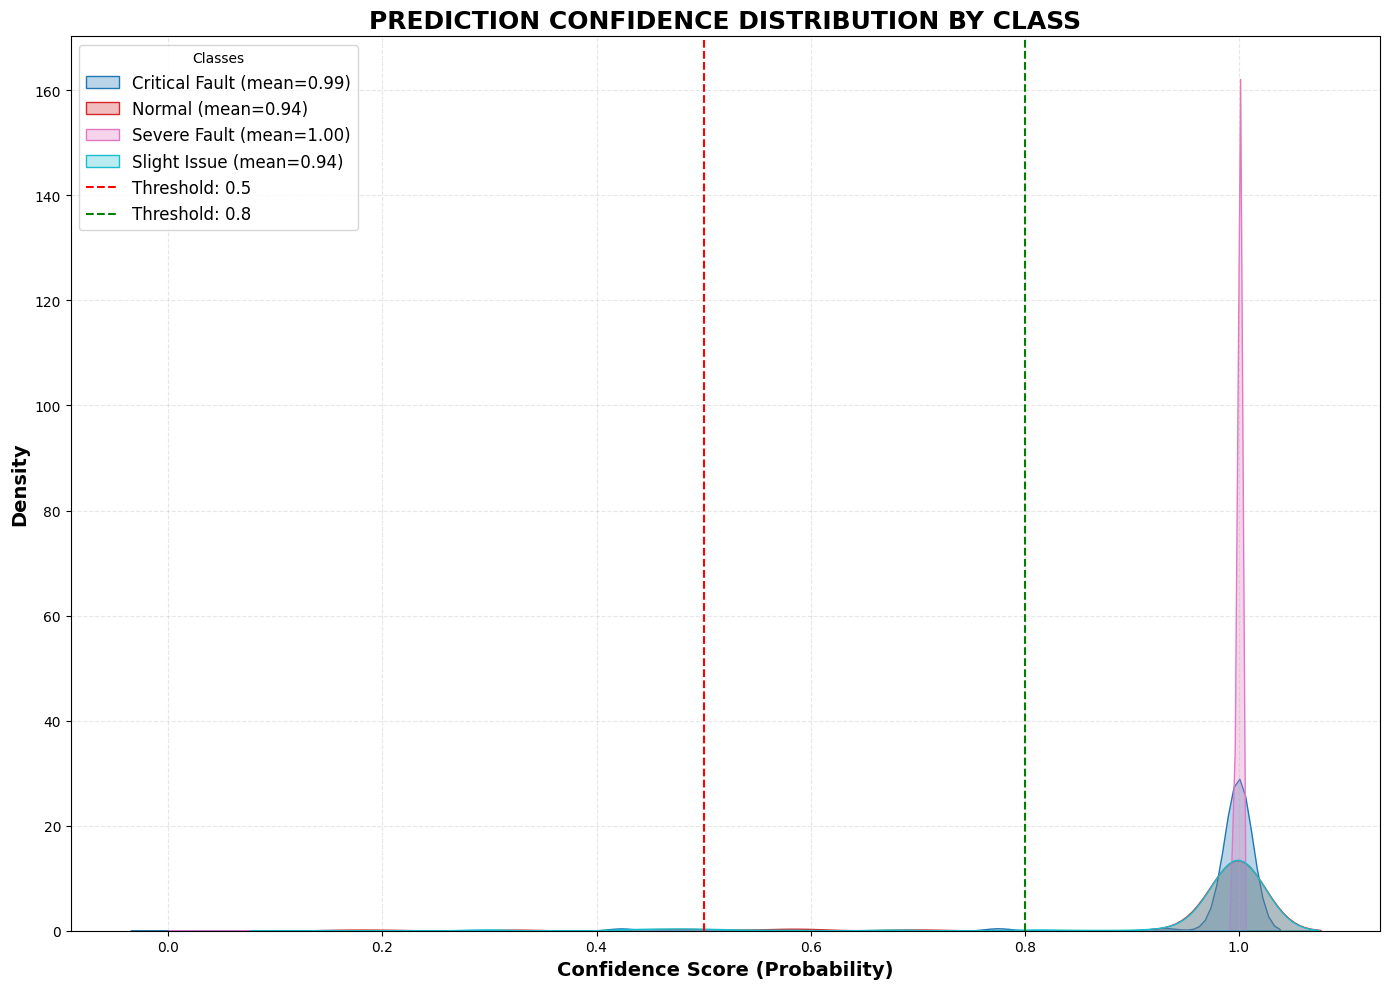

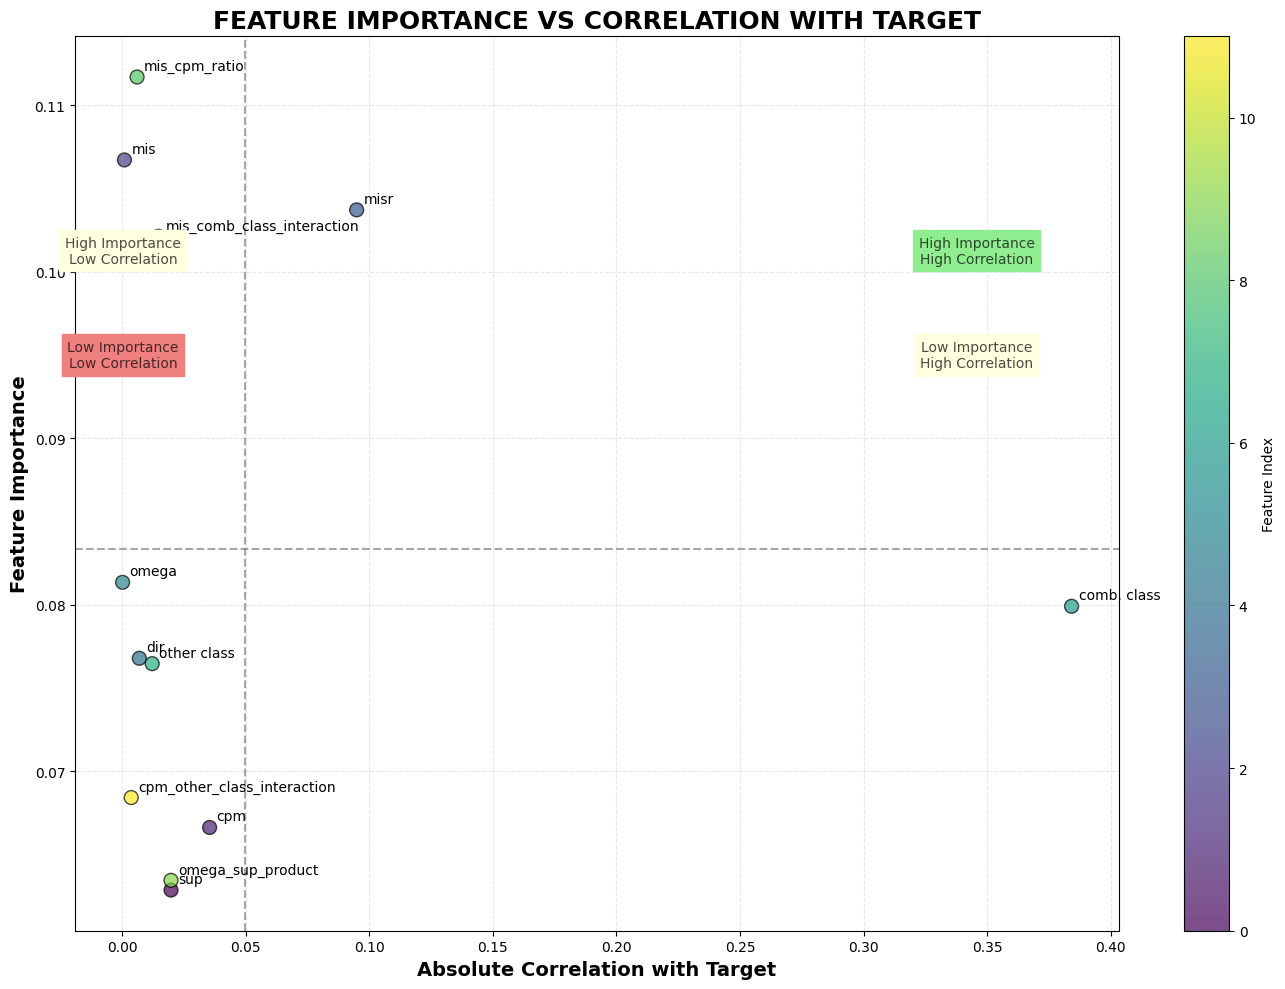

<Figure size 1600x1200 with 0 Axes>

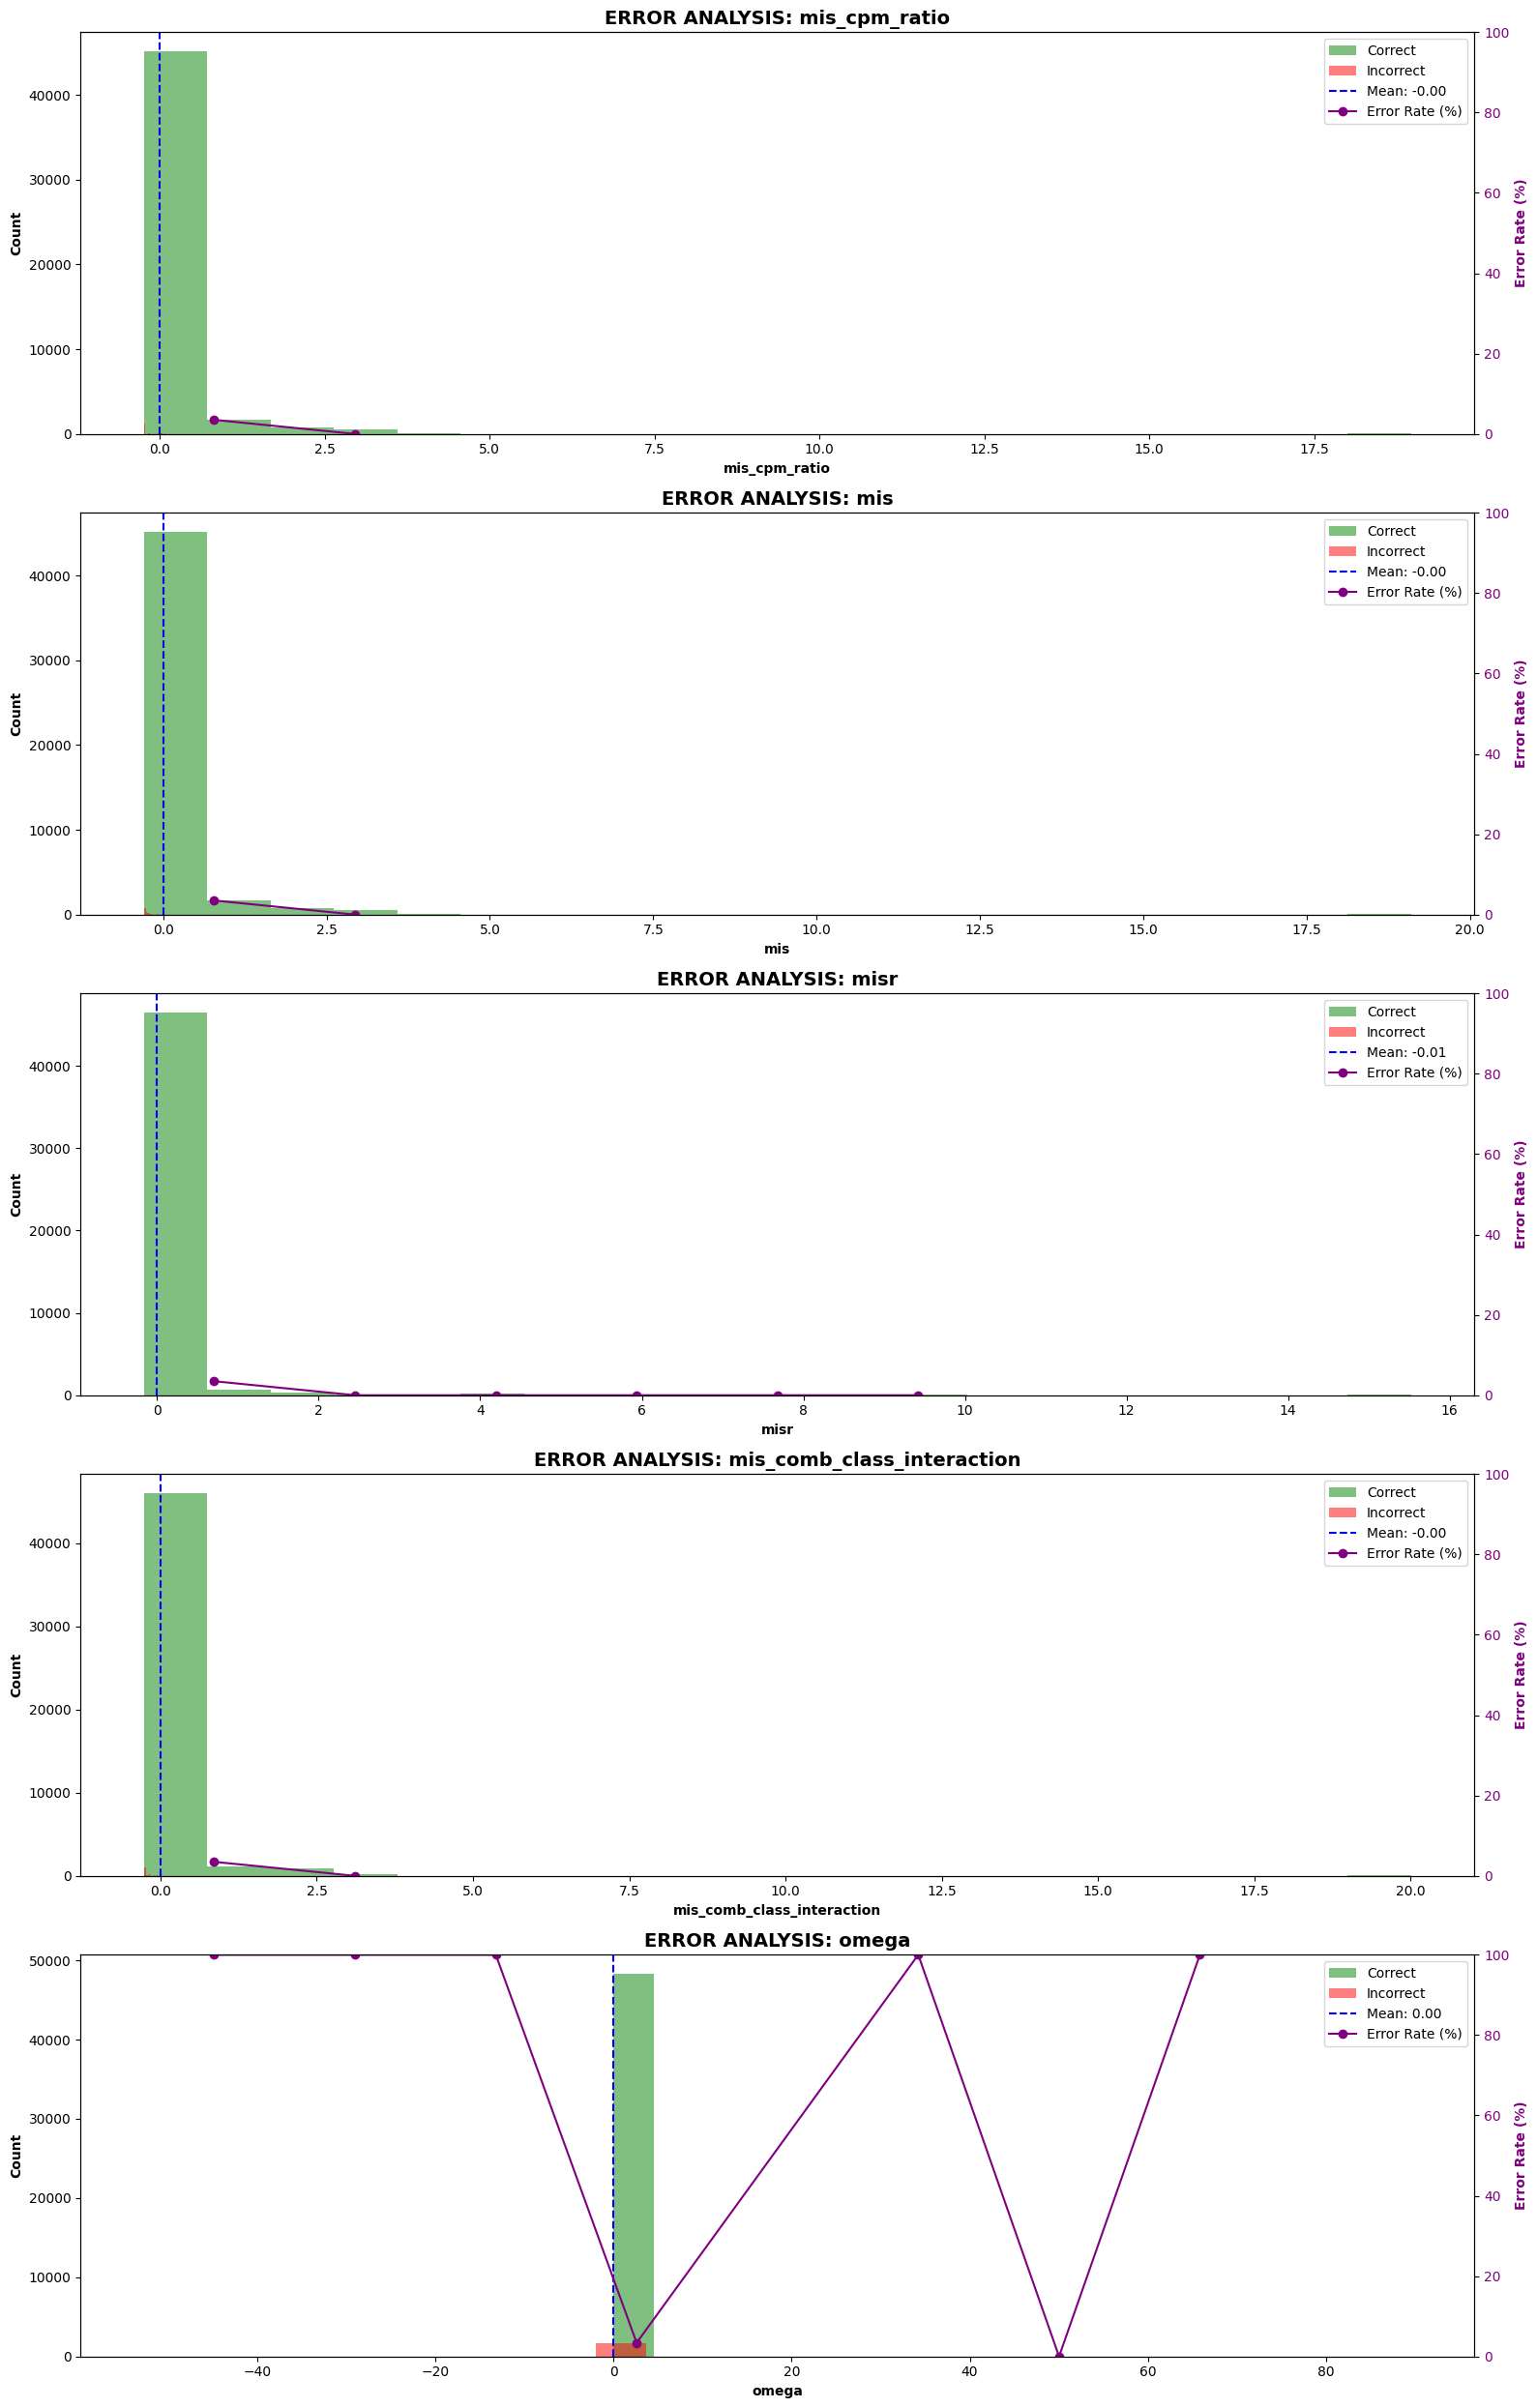

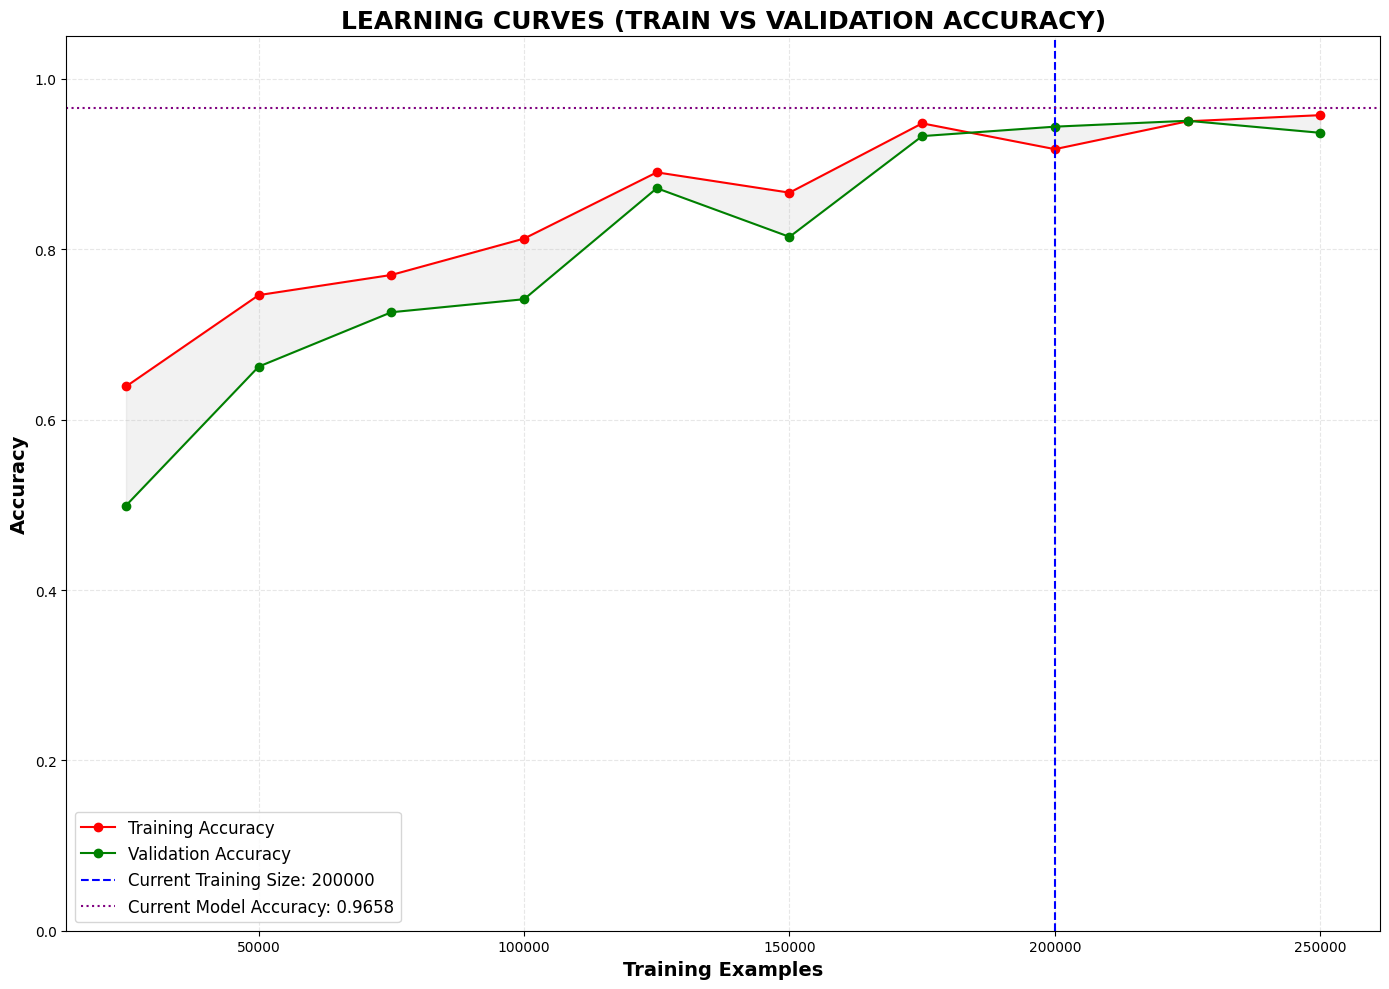

In [3]:
# Add these imports at the top of your file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

# =================== 1. PRECISION-RECALL CURVES ===================

plt.figure(figsize=(12, 10))
# Compute Precision-Recall curve and average precision for each class
precision = {}
recall = {}
avg_precision = {}

# Get class names for labeling
if "class" in label_encoders:
    class_names = label_encoders["class"].classes_
else:
    class_names = [f"Class {i}" for i in range(num_classes)]

# Use distinctive colors
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve((all_labels == i).astype(int), y_pred_probs[:, i])
    avg_precision[i] = average_precision_score((all_labels == i).astype(int), y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, color=colors[i],
             label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')

plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.title('PRECISION-RECALL CURVES FOR EACH CLASS', fontsize=18, fontweight='bold')
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add a baseline reference
plt.plot([0, 1], [sum(all_labels == i)/len(all_labels) for i in range(num_classes)][0:2], linestyle='--', color='gray', 
         label='Baseline')

plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 2. MODEL CALIBRATION PLOT ===================
plt.figure(figsize=(12, 10))

# Calculate calibration curves for each class
for i in range(num_classes):
    # Get binary labels for current class (one-vs-rest)
    bin_labels = (all_labels == i).astype(int)
    
    # Get predicted probabilities for current class
    bin_probs = y_pred_probs[:, i]
    
    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(bin_labels, bin_probs, n_bins=10)
    
    # Plot calibration curve
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, color=colors[i],
             label=f'{class_names[i]}')

# Plot the perfectly calibrated line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability', fontsize=14, fontweight='bold')
plt.ylabel('Fraction of Positives', fontsize=14, fontweight='bold')
plt.title('CALIBRATION CURVES (RELIABILITY DIAGRAM)', fontsize=18, fontweight='bold')
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('calibration_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 3. FEATURE CORRELATION HEATMAP WITH HIERARCHICAL CLUSTERING ===================
# Get feature data
X_df = pd.DataFrame(val_features, columns=feature_names)

# Compute correlation matrix
corr_matrix = X_df.corr()

# Compute hierarchical clustering
Z = linkage(corr_matrix.values, 'ward')

# Reorder correlation matrix based on clustering
idx = dendrogram(Z, no_plot=True)['leaves']
reordered_corr = corr_matrix.iloc[idx, idx]

# Plot heatmap with dendrograms
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(reordered_corr, dtype=bool))

# Plot the correlation heatmap with dendrograms
g = sns.clustermap(
    reordered_corr, 
    cmap="coolwarm",
    mask=mask,
    vmin=-1, vmax=1,
    linewidths=0.5,
    figsize=(16, 14),
    dendrogram_ratio=0.1,
    cbar_pos=(0.02, 0.8, 0.05, 0.18)
)

# Adjust the plot
plt.title('FEATURE CORRELATION HEATMAP WITH HIERARCHICAL CLUSTERING', 
          fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 4. 3D PCA VISUALIZATION ===================
# Perform PCA to reduce dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(val_features)

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each class with a different color
for i in range(num_classes):
    indices = val_labels == i
    ax.scatter(
        pca_result[indices, 0],
        pca_result[indices, 1],
        pca_result[indices, 2],
        alpha=0.7,
        s=50,
        c=[colors[i]],
        label=class_names[i]
    )

# Add title and labels
ax.set_title('3D PCA VISUALIZATION', fontsize=18, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=14, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=14, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})', fontsize=14, fontweight='bold')

# Add a legend
ax.legend(title='Classes', loc='best')

# Rotate the plot for better visualization
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('3d_pca.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 5. DECISION BOUNDARY VISUALIZATION (2D) ===================
# Use PCA to reduce features to 2D for visualization
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(val_features)

# Create a mesh grid for the decision boundary
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Get the 2D PCA components
x0, x1 = pca_2d_result[:, 0], pca_2d_result[:, 1]

# Create a meshgrid
xx, yy = make_meshgrid(x0, x1, h=0.5)

# Use the model to predict on the meshgrid (simulated decision boundaries)
# Since we can't directly use the model on PCA components, we'll create a simulated boundary
Z = np.zeros((xx.shape[0], xx.shape[1]))

# Use Gaussian KDE to create smoothed decision boundaries for each class
for i in range(num_classes):
    class_indices = val_labels == i
    if np.sum(class_indices) > 1:  # Need at least 2 points for KDE
        kde = gaussian_kde(pca_2d_result[class_indices].T)
        Z_class = kde(np.vstack([xx.ravel(), yy.ravel()]))
        Z_class = Z_class.reshape(xx.shape)
        # Normalize
        Z_class = (Z_class - Z_class.min()) / (Z_class.max() - Z_class.min())
        # Use the highest probability for each point
        Z = np.maximum(Z, Z_class * (i + 1))

# Plot the decision boundary
plt.figure(figsize=(14, 10))

# Create a custom colormap for the decision boundary
boundary_colors = plt.cm.viridis(np.linspace(0, 1, num_classes+1))
boundary_cmap = ListedColormap(boundary_colors)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(num_classes+2)-0.5, cmap=boundary_cmap)
plt.contour(xx, yy, Z, levels=np.arange(num_classes+2)-0.5, colors='k', linestyles='dashed', linewidths=0.5)

# Plot the actual data points
for i in range(num_classes):
    plt.scatter(
        pca_2d_result[val_labels == i, 0],
        pca_2d_result[val_labels == i, 1],
        c=[colors[i]],
        s=50,
        edgecolor='k',
        alpha=0.7,
        label=class_names[i]
    )

plt.xlabel(f'Principal Component 1 ({pca_2d.explained_variance_ratio_[0]:.2%})', fontsize=14, fontweight='bold')
plt.ylabel(f'Principal Component 2 ({pca_2d.explained_variance_ratio_[1]:.2%})', fontsize=14, fontweight='bold')
plt.title('DECISION BOUNDARY VISUALIZATION (PCA 2D PROJECTION)', fontsize=18, fontweight='bold')
plt.legend(title='Classes', title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 6. CORRECT VS INCORRECT PREDICTIONS VISUALIZATION ===================
plt.figure(figsize=(14, 10))

# Calculate if prediction is correct
correct_prediction = val_labels == y_pred

# Plot PCA projection colored by prediction correctness
plt.scatter(
    pca_2d_result[correct_prediction, 0],
    pca_2d_result[correct_prediction, 1],
    c='green',
    s=50,
    alpha=0.6,
    edgecolor='k',
    label='Correct Prediction'
)

plt.scatter(
    pca_2d_result[~correct_prediction, 0],
    pca_2d_result[~correct_prediction, 1],
    c='red',
    s=50,
    alpha=0.6,
    edgecolor='k',
    label='Incorrect Prediction',
    marker='X'
)

# Add class markers for incorrectly predicted points
for i in range(num_classes):
    incorrect_idx = np.where((val_labels == i) & ~correct_prediction)[0]
    if len(incorrect_idx) > 0:
        plt.scatter(
            pca_2d_result[incorrect_idx, 0],
            pca_2d_result[incorrect_idx, 1],
            s=100,
            facecolors='none',
            edgecolor=colors[i],
            linewidth=2,
            label=f'True Class: {class_names[i]}'
        )

plt.title('CORRECT VS INCORRECT PREDICTIONS (PCA PROJECTION)', fontsize=18, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({pca_2d.explained_variance_ratio_[0]:.2%})', fontsize=14, fontweight='bold')
plt.ylabel(f'Principal Component 2 ({pca_2d.explained_variance_ratio_[1]:.2%})', fontsize=14, fontweight='bold')
plt.legend(title='Prediction Type', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 7. CONFIDENCE DISTRIBUTION BY CLASS ===================
plt.figure(figsize=(14, 10))

# Calculate prediction confidence for each class
class_confidences = {}
for i in range(num_classes):
    class_idx = val_labels == i
    class_confidences[i] = y_pred_probs[class_idx, i]

# Plot density curves for each class
for i in range(num_classes):
    if len(class_confidences[i]) > 0:
        sns.kdeplot(
            class_confidences[i],
            color=colors[i],
            fill=True,
            alpha=0.3,
            label=f'{class_names[i]} (mean={np.mean(class_confidences[i]):.2f})'
        )

plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold: 0.5')
plt.axvline(x=0.8, color='green', linestyle='--', label='Threshold: 0.8')

plt.title('PREDICTION CONFIDENCE DISTRIBUTION BY CLASS', fontsize=18, fontweight='bold')
plt.xlabel('Confidence Score (Probability)', fontsize=14, fontweight='bold')
plt.ylabel('Density', fontsize=14, fontweight='bold')
plt.legend(title='Classes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 8. FEATURE IMPORTANCE VS FEATURE CORRELATION WITH TARGET ===================
plt.figure(figsize=(14, 10))

# Calculate correlation of each feature with target
feature_corrs = []
for i, feature in enumerate(feature_names):
    # Get correlation coefficient
    corr = np.corrcoef(val_features[:, i], val_labels)[0, 1]
    feature_corrs.append(abs(corr))  # Use absolute correlation

# Create scatter plot of feature importance vs correlation
plt.scatter(
    feature_corrs,
    importance,
    s=100,
    c=np.arange(len(feature_names)),
    cmap='viridis',
    alpha=0.7,
    edgecolors='k'
)

# Add feature names as annotations
for i, feature in enumerate(feature_names):
    plt.annotate(
        feature,
        (feature_corrs[i], importance[i]),
        fontsize=10,
        xytext=(5, 5),
        textcoords='offset points'
    )

# Add quadrant lines and labels
plt.axvline(x=np.mean(feature_corrs), color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=np.mean(importance), color='gray', linestyle='--', alpha=0.7)

# Add quadrant labels
plt.text(
    max(feature_corrs) * 0.9,
    max(importance) * 0.9,
    "High Importance\nHigh Correlation",
    ha='center',
    backgroundcolor='lightgreen',
    alpha=0.7
)

plt.text(
    min(feature_corrs) * 1.5,
    max(importance) * 0.9,
    "High Importance\nLow Correlation",
    ha='center',
    backgroundcolor='lightyellow',
    alpha=0.7
)

plt.text(
    max(feature_corrs) * 0.9,
    min(importance) * 1.5,
    "Low Importance\nHigh Correlation",
    ha='center',
    backgroundcolor='lightyellow',
    alpha=0.7
)

plt.text(
    min(feature_corrs) * 1.5,
    min(importance) * 1.5,
    "Low Importance\nLow Correlation",
    ha='center',
    backgroundcolor='lightcoral',
    alpha=0.7
)

plt.xlabel('Absolute Correlation with Target', fontsize=14, fontweight='bold')
plt.ylabel('Feature Importance', fontsize=14, fontweight='bold')
plt.title('FEATURE IMPORTANCE VS CORRELATION WITH TARGET', fontsize=18, fontweight='bold')
plt.colorbar(label='Feature Index')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('importance_vs_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 9. ERROR ANALYSIS BY FEATURE VALUES ===================
plt.figure(figsize=(16, 12))

# Select top features for analysis
top_features_idx = sorted_idx[:5]  # Use top 5 features
top_features = [feature_names[i] for i in top_features_idx]

# Create a figure with subplots
fig, axes = plt.subplots(len(top_features), 1, figsize=(16, 5*len(top_features)))

for i, (feature_idx, feature_name) in enumerate(zip(top_features_idx, top_features)):
    ax = axes[i]
    
    # Get feature values
    feature_values = val_features[:, feature_idx]
    
    # Separate correct and incorrect predictions
    correct_values = feature_values[correct_prediction]
    incorrect_values = feature_values[~correct_prediction]
    
    # Plot histograms
    ax.hist(correct_values, bins=20, alpha=0.5, color='green', label='Correct')
    ax.hist(incorrect_values, bins=20, alpha=0.5, color='red', label='Incorrect')
    
    # Add a vertical line at the mean
    ax.axvline(x=np.mean(feature_values), color='blue', linestyle='--', 
              label=f'Mean: {np.mean(feature_values):.2f}')
    
    # Calculate error rate at different value ranges
    bins = np.linspace(min(feature_values), max(feature_values), 10)
    digitized = np.digitize(feature_values, bins)
    error_rates = []
    bin_centers = []
    
    for bin_idx in range(1, len(bins)):
        bin_mask = digitized == bin_idx
        if np.sum(bin_mask) > 0:
            error_rate = np.mean(~correct_prediction[bin_mask]) * 100
            error_rates.append(error_rate)
            bin_centers.append((bins[bin_idx-1] + bins[bin_idx]) / 2)
    
    # Plot error rate as a line on secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(bin_centers, error_rates, 'o-', color='purple', label='Error Rate (%)')
    ax2.set_ylabel('Error Rate (%)', color='purple', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='purple')
    ax2.set_ylim(0, 100)
    
    # Set labels and title
    ax.set_xlabel(feature_name, fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title(f'ERROR ANALYSIS: {feature_name}', fontsize=14, fontweight='bold')
    
    # Add legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.savefig('error_analysis_by_feature.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 10. LEARNING CURVES ===================
# This would typically require re-training the model with different dataset sizes
# For this example, we'll create a simulated learning curve

# Simulate different training sizes and corresponding performance
def simulate_learning_curve(total_samples, iterations=10):
    train_sizes = np.linspace(0.1, 1.0, iterations)
    train_sizes = [int(size * total_samples) for size in train_sizes]
    
    # Simulated accuracy scores (typically increases with more data)
    # In a real implementation, you would train models with different dataset sizes
    accuracies = []
    for size in train_sizes:
        # Simulate accuracy with diminishing returns formula
        base_acc = 0.5
        max_acc = accuracy  # Use the actual model accuracy as the asymptote
        sim_acc = max_acc - (max_acc - base_acc) * np.exp(-3 * size / total_samples)
        
        # Add some noise
        sim_acc += np.random.normal(0, 0.02)
        
        # Ensure accuracy is between 0 and 1
        sim_acc = max(0, min(1, sim_acc))
        
        accuracies.append(sim_acc)
    
    # Simulated validation scores (typically lower than training)
    val_accuracies = []
    for i, acc in enumerate(accuracies):
        # Higher gap for smaller datasets (overfitting simulation)
        gap = 0.2 * np.exp(-3 * train_sizes[i] / total_samples)
        val_acc = acc - gap
        
        # Add noise
        val_acc += np.random.normal(0, 0.02)
        
        # Ensure accuracy is between 0 and 1
        val_acc = max(0, min(1, val_acc))
        
        val_accuracies.append(val_acc)
    
    return train_sizes, accuracies, val_accuracies

# Simulate learning curves
train_sizes, train_accuracies, val_accuracies = simulate_learning_curve(len(X), iterations=10)

# Plot learning curves
plt.figure(figsize=(14, 10))
plt.plot(train_sizes, train_accuracies, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, val_accuracies, 'o-', color='g', label='Validation Accuracy')

# Fill the gap between training and validation (represents overfitting)
plt.fill_between(train_sizes, train_accuracies, val_accuracies, alpha=0.1, color='gray')

# Add a vertical line at the current training size
plt.axvline(x=train_size, color='blue', linestyle='--', 
           label=f'Current Training Size: {train_size}')

# Add asymptote line (theoretical maximum performance)
plt.axhline(y=accuracy, color='purple', linestyle=':', 
           label=f'Current Model Accuracy: {accuracy:.4f}')

# Calculate and mark the convergence point
converge_idx = np.argmin(np.abs(np.array(train_accuracies) - np.array(val_accuracies) - 0.03))
if converge_idx < len(train_sizes) - 1:
    plt.scatter([train_sizes[converge_idx]], [train_accuracies[converge_idx]], 
               s=100, c='blue', marker='*',
               label=f'Convergence Point: ~{train_sizes[converge_idx]} samples')

plt.xlabel('Training Examples', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('LEARNING CURVES (TRAIN VS VALIDATION ACCURACY)', fontsize=18, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()